In [1]:
!pip install wordcloud

In [1]:
import urllib.request
import json 
import datetime

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn

from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pprint import pprint
from IPython import display

We now need to download the lexicon for NLTK, that will be used to analyze the words extracted from Reddit titles. [VADER] (Valence Aware Dictionary and sEntiment Reasoner) is used as the pre-trained model.

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\deepa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Next, we pre-defined the style for Seaborn, the graphing library we will be using down the line.

In [3]:
seaborn.set(style='darkgrid', context='talk', palette='Dark2')

<!-- Now we can define a function that will use the PushShift API to pull in historical Reddit post information. We could use a library like [praw](https://praw.readthedocs.io/en/latest/), however it's capabilities are limited given some [Reddit API changes](https://stackoverflow.com/a/54046328/303696) that restrict timeframe-based lookups. -->

In [4]:
def load_results(lower_bound_timestamp, upper_bound_timestamp, target_result_size, target_subreddit, score_threshold):
    headline_collection = set()
    
    reddit_data_url = f"https://api.pushshift.io/reddit/submission/search/?after={lower_bound_timestamp}&before={upper_bound_timestamp}&sort_type=score&sort=desc&subreddit={target_subreddit}&size={target_result_size}&score={score_threshold}"
    
    try:
        with urllib.request.urlopen(reddit_data_url) as url:
            data = json.loads(url.read().decode())
            
            for submission in data['data']:
                headline_collection.add(submission['title'])

        return headline_collection
    except urllib.error.HTTPError as e:
        print(e.__dict__)
        return set()
    except urllib.error.URLError as e:
        print(e.__dict__)
        return set()

<!-- Next, we can perform a range of queries against the API to get sets of Reddit posts that match our criteria - coming from the `dotnet` subreddit, and with a score of more than 10. We are also starting the lookup at a date one year ago from today, and sliding the lookup window by 5 days in each call. Using `union()` for set merges ensures that we are not duplicating titles that we are inspecting. -->

In [5]:
headlines = set()

time_now = datetime.datetime.now()

limit_delta = 365
limit_lower_delta = 360

subreddit = "college"
result_size = 1000
score_limit = ">10"

for i in range(0, 73):
    previous_timestamp = int((time_now - datetime.timedelta(days=limit_delta)).timestamp())
    current_timestamp = int((time_now - datetime.timedelta(days=limit_lower_delta)).timestamp())

    full_collection = load_results(previous_timestamp, current_timestamp, result_size, subreddit, score_limit)
    headlines = headlines.union(full_collection)
    
    limit_delta = limit_delta - 5
    limit_lower_delta = limit_lower_delta - 5
    
    display.clear_output()
    print(f"Cycle {i}")
    print(len(headlines))

Cycle 72
266


To get the sentiment, we need to calculate the polarity scores for each line that we have in the set.

In [6]:
sia = SentimentIntensityAnalyzer()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

pprint(results[:5], width=100)

[{'compound': 0.0,
  'headline': 'Tossed the exam day I got it back…',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': 0.3182,
  'headline': 'Please read your course syllabi',
  'neg': 0.0,
  'neu': 0.635,
  'pos': 0.365},
 {'compound': 0.872,
  'headline': 'What are some of the best books that have helped you succeed in college/university '
              'that you would recommend to new students?',
  'neg': 0.0,
  'neu': 0.645,
  'pos': 0.355},
 {'compound': -0.5423,
  'headline': 'Have you ever just said fuck it and not did an assignment?',
  'neg': 0.241,
  'neu': 0.759,
  'pos': 0.0},
 {'compound': 0.0,
  'headline': 'I’m afraid to what’s going to happen to me after I graduate.',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0}]


Converting the results to a data frame makes it much easier to operate, so we will do just that.

In [7]:
df = pd.DataFrame.from_records(results)
df.head()

neg    neu    pos  compound  \
0  0.000  1.000  0.000    0.0000   
1  0.000  0.635  0.365    0.3182   
2  0.000  0.645  0.355    0.8720   
3  0.241  0.759  0.000   -0.5423   
4  0.000  1.000  0.000    0.0000   

                                            headline  
0                 Tossed the exam day I got it back…  
1                    Please read your course syllabi  
2  What are some of the best books that have help...  
3  Have you ever just said fuck it and not did an...  
4  I’m afraid to what’s going to happen to me aft...

Based on the compound assessed value, we can determine whether the headline that we are analyzing is positive or negative. We can label that accordingly with a `1` value for positive sentiment and `-1` value for negative sentiment.

In [8]:
df['label'] = 0
df.loc[df['compound'] > 0.1, 'label'] = 1
df.loc[df['compound'] < -0.1, 'label'] = -1
df.head()

neg    neu    pos  compound  \
0  0.000  1.000  0.000    0.0000   
1  0.000  0.635  0.365    0.3182   
2  0.000  0.645  0.355    0.8720   
3  0.241  0.759  0.000   -0.5423   
4  0.000  1.000  0.000    0.0000   

                                            headline  label  
0                 Tossed the exam day I got it back…      0  
1                    Please read your course syllabi      1  
2  What are some of the best books that have help...      1  
3  Have you ever just said fuck it and not did an...     -1  
4  I’m afraid to what’s going to happen to me aft...      0

Now, we can isolate the headlines and labels into a separate data frame, and store the data in a CSV file that we can work with later on - that way, it won't be necessary to re-download the content over and over again for every run.

In [9]:
working_dataframe = df[['headline', 'label']]
working_dataframe.to_csv('labeled-data-set.csv', mode='a', encoding='utf-8', index=False)

Let's take a look at what headlines we have.

In [10]:
print("Positive headlines:\n")
pprint(list(df[df['label'] == 1].headline)[:20], width=200)

print("\nNegative headlines:\n")
pprint(list(df[df['label'] == -1].headline)[:20], width=200)

Positive headlines:

['Please read your course syllabi',
 'What are some of the best books that have helped you succeed in college/university that you would recommend to new students?',
 'I honestly owe my tuition to the Organic Chemistry Tutor and Professor Leonard',
 'What degree do you wish you studied?',
 'How to push myself to join groups as an introvert?',
 'Are diversity scholarships ethical?',
 "I GOT PRESIDENT'S LIST!!! 😭😭😭😭😭😭 ( but the excitement only lasted a few minutes☺)",
 'The reverse can also be true.',
 'Confession: I’m pretty much doing college so that I can put that I have a bachelor’s degree on my resume.',
 'How am I supposed to do therapy online when I have a roommate?? There is nowhere to get any privacy and I don’t see how I would want to talk about anything with someone else in the room.',
 'Anyone love doing ironic assignments',
 'Does it get easier in College?',
 'I wish you all well this year!',
 'This physics class is amazing!!',
 'To the professors that em

Now, we want to generate a word cloud for both the negative and the positive headlines, to see if there are any frequently-occurring words. To do that, we will isolate the dataframe columns.

In [11]:
negative_titles = df[df['label'] == -1]
negative_titles.head()

neg    neu    pos  compound  \
3   0.241  0.759  0.000   -0.5423   
5   0.538  0.462  0.000   -0.5423   
7   0.068  0.887  0.044   -0.1779   
9   0.219  0.781  0.000   -0.4215   
10  0.174  0.826  0.000   -0.4101   

                                             headline  label  
3   Have you ever just said fuck it and not did an...     -1  
5                                 Am I going to fail?     -1  
7   I am a US citizen and have lived my entire lif...     -1  
9   Do Any of You Regret Choosing the College Majo...     -1  
10  I’m a gay guy moving to college and am so nerv...     -1

With negative titles separate, we can now run that through `WordCloud` to get the rendering.

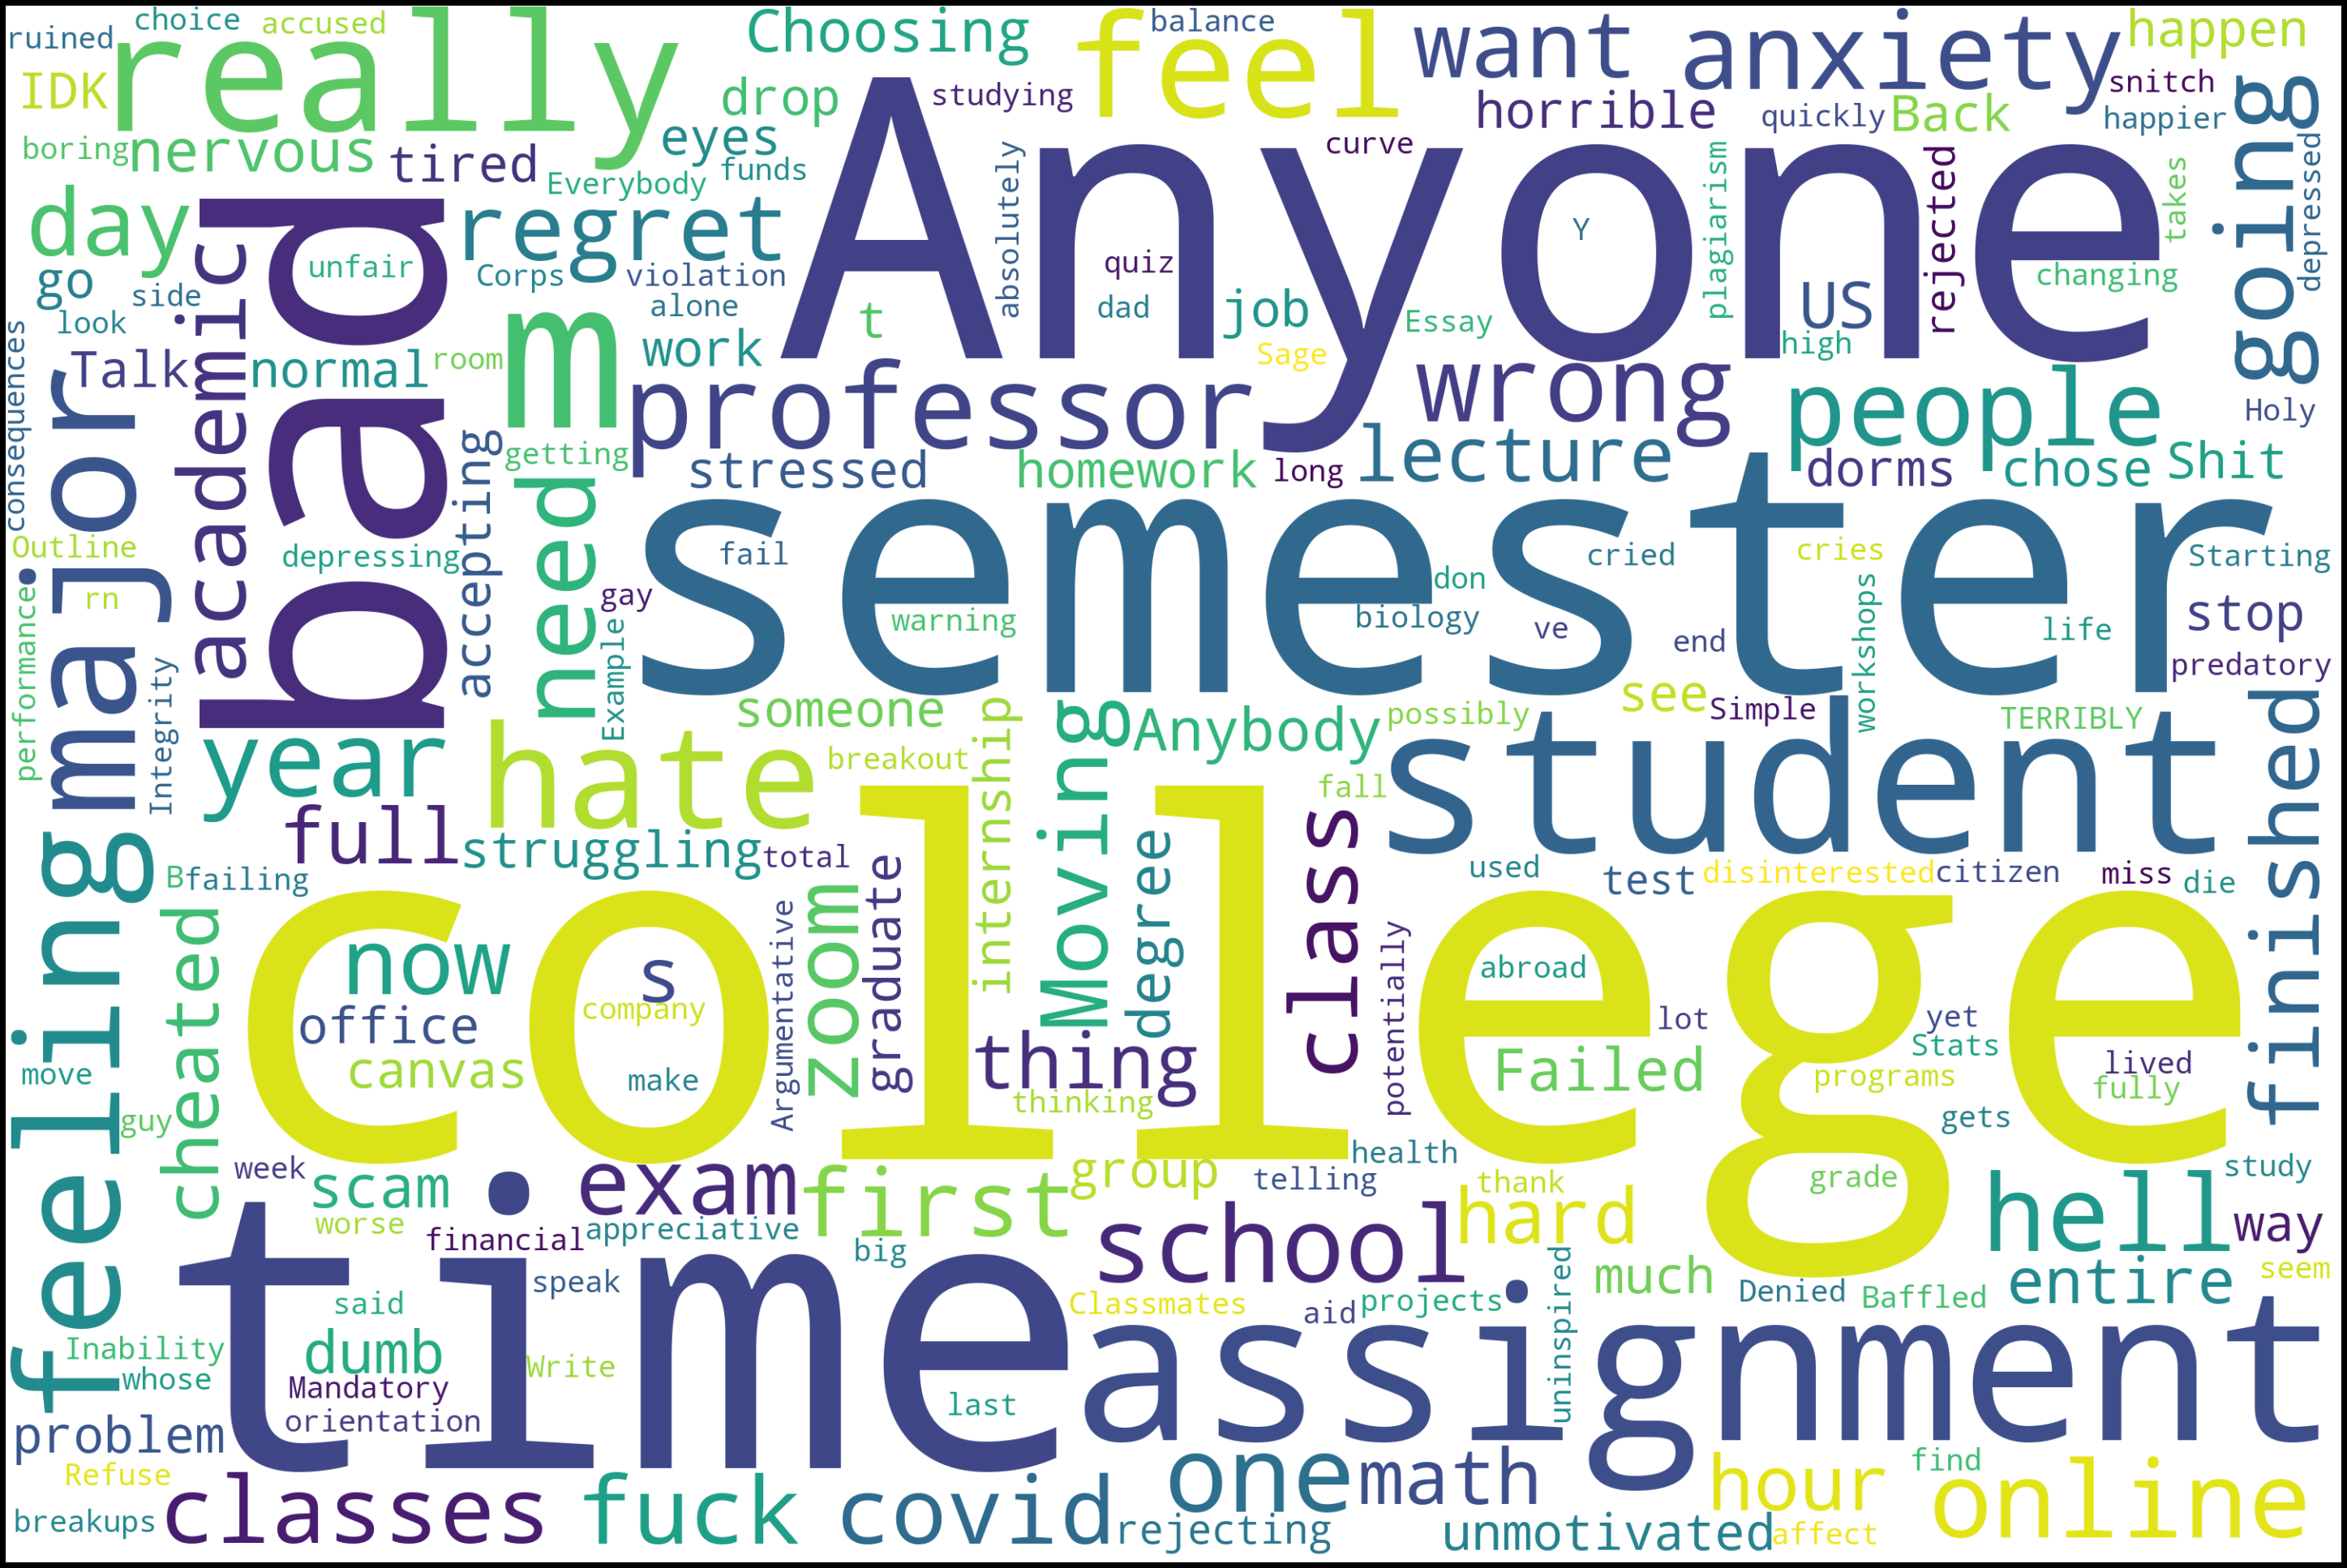

In [12]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(' '.join(negative_titles['headline']))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

We do the same isolation for positive titles.

In [13]:
positive_titles = df[df['label'] == 1]
positive_titles.head()

neg    neu    pos  compound  \
1   0.0  0.635  0.365    0.3182   
2   0.0  0.645  0.355    0.8720   
6   0.0  0.786  0.214    0.4588   
19  0.0  0.690  0.310    0.4019   
28  0.0  0.804  0.196    0.2960   

                                             headline  label  
1                     Please read your course syllabi      1  
2   What are some of the best books that have help...      1  
6   I honestly owe my tuition to the Organic Chemi...      1  
19               What degree do you wish you studied?      1  
28  How to push myself to join groups as an introv...      1

And render the cloud.

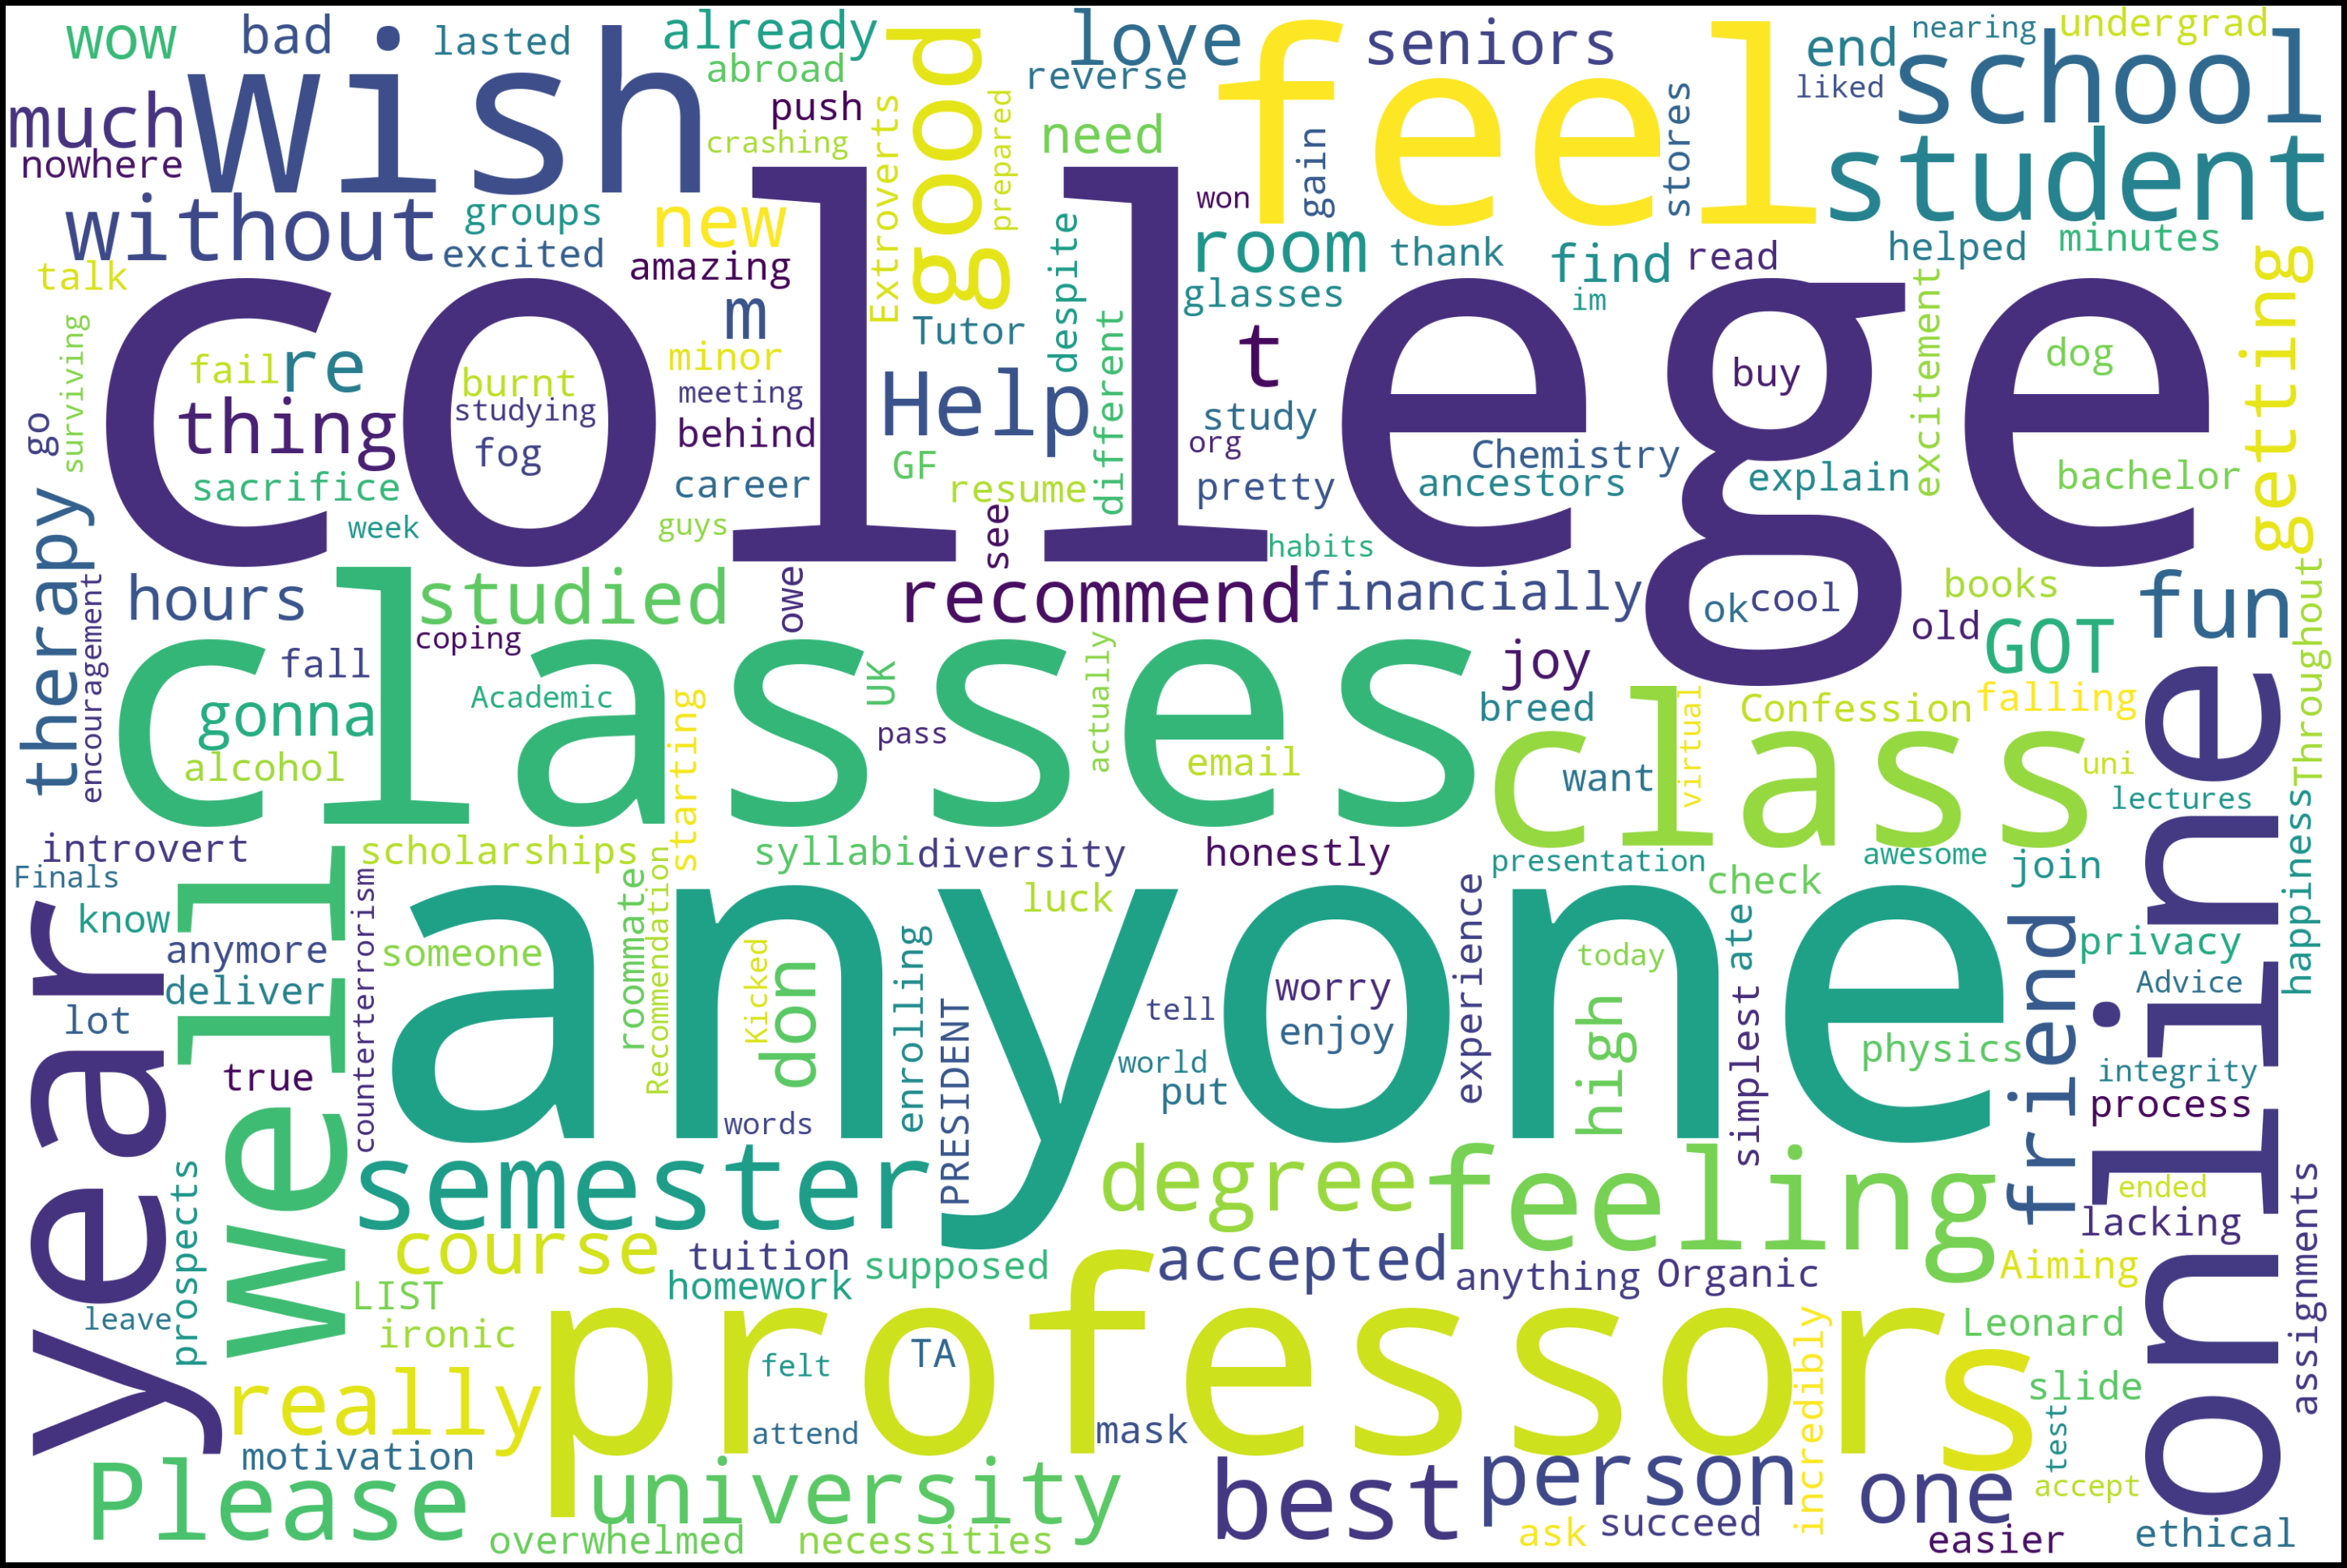

In [14]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(' '.join(positive_titles['headline']))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Last but not least, we will calculate the counts of negative, neutral and positive titles in the set that we obtained.

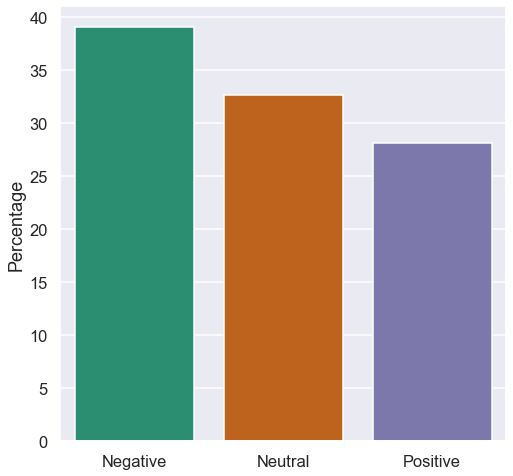

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.label.value_counts(normalize=True) * 100

seaborn.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [16]:
!pip install facebook_scraper

In [17]:
#facebook extraction

In [18]:
from facebook_scraper import get_posts
import pandas as pd
import facebook_scraper as fs
listposts = []

for post in get_posts("Anuraguniversity", pages=10):
    print(post['text'][:50])
    listposts.append(post)

#posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])
print(listposts)


Celebrating all Padma Shri awardees for their exce
Can you solve these puzzles? National Mathematics 
No amount of posts can honour the martyrs who sacr
Energy conservation should be entrenched in every 
Every child has the right to grow up in a safe and
What makes a better world for you? For us, it mean
Women’s safety is of priority in world where every
India is one of the greatest agricultural nations 
Attention all the photography enthusiasts. The Cli
Attention all the photography enthusiasts. The Cli
When basic human rights are respected, people can 
In 1948, Dr Ambedkar completed the draft of the In
THE TV SERIES OF LIFE WE ALL MUST BINGE-WATCH.

#W
Tomorrow's entrepreneurs, your time is now. This i
May you never grow up!
#happychildrensday
Make someone’s day better, make someone’s tomorrow
Maulana Abul Kalam Azad, the first education minis
This National Cancer Awareness Day, let us all tak
May this Diwali open new doors and light your path
Congrats to all management aspirants. Yo

In [19]:
results = []
for line in listposts:
    pol_score = sia.polarity_scores(line['text'])
    pol_score['headline'] = line['text']
    results.append(pol_score)

In [20]:
line['text']
df1 = pd.DataFrame(results)

In [21]:
df1['label'] = 0
df1.loc[df1['compound'] > 0.1, 'label'] = 1
df1.loc[df1['compound'] < -0.1, 'label'] = -1
df1.head()

neg    neu    pos  compound  \
0  0.027  0.781  0.192    0.8266   
1  0.000  0.801  0.199    0.9882   
2  0.173  0.732  0.095   -0.8271   
3  0.000  0.824  0.176    0.8176   
4  0.027  0.820  0.152    0.8621   

                                            headline  label  
0  Celebrating all Padma Shri awardees for their ...      1  
1  Can you solve these puzzles? National Mathemat...      1  
2  No amount of posts can honour the martyrs who ...     -1  
3  Energy conservation should be entrenched in ev...      1  
4  Every child has the right to grow up in a safe...      1

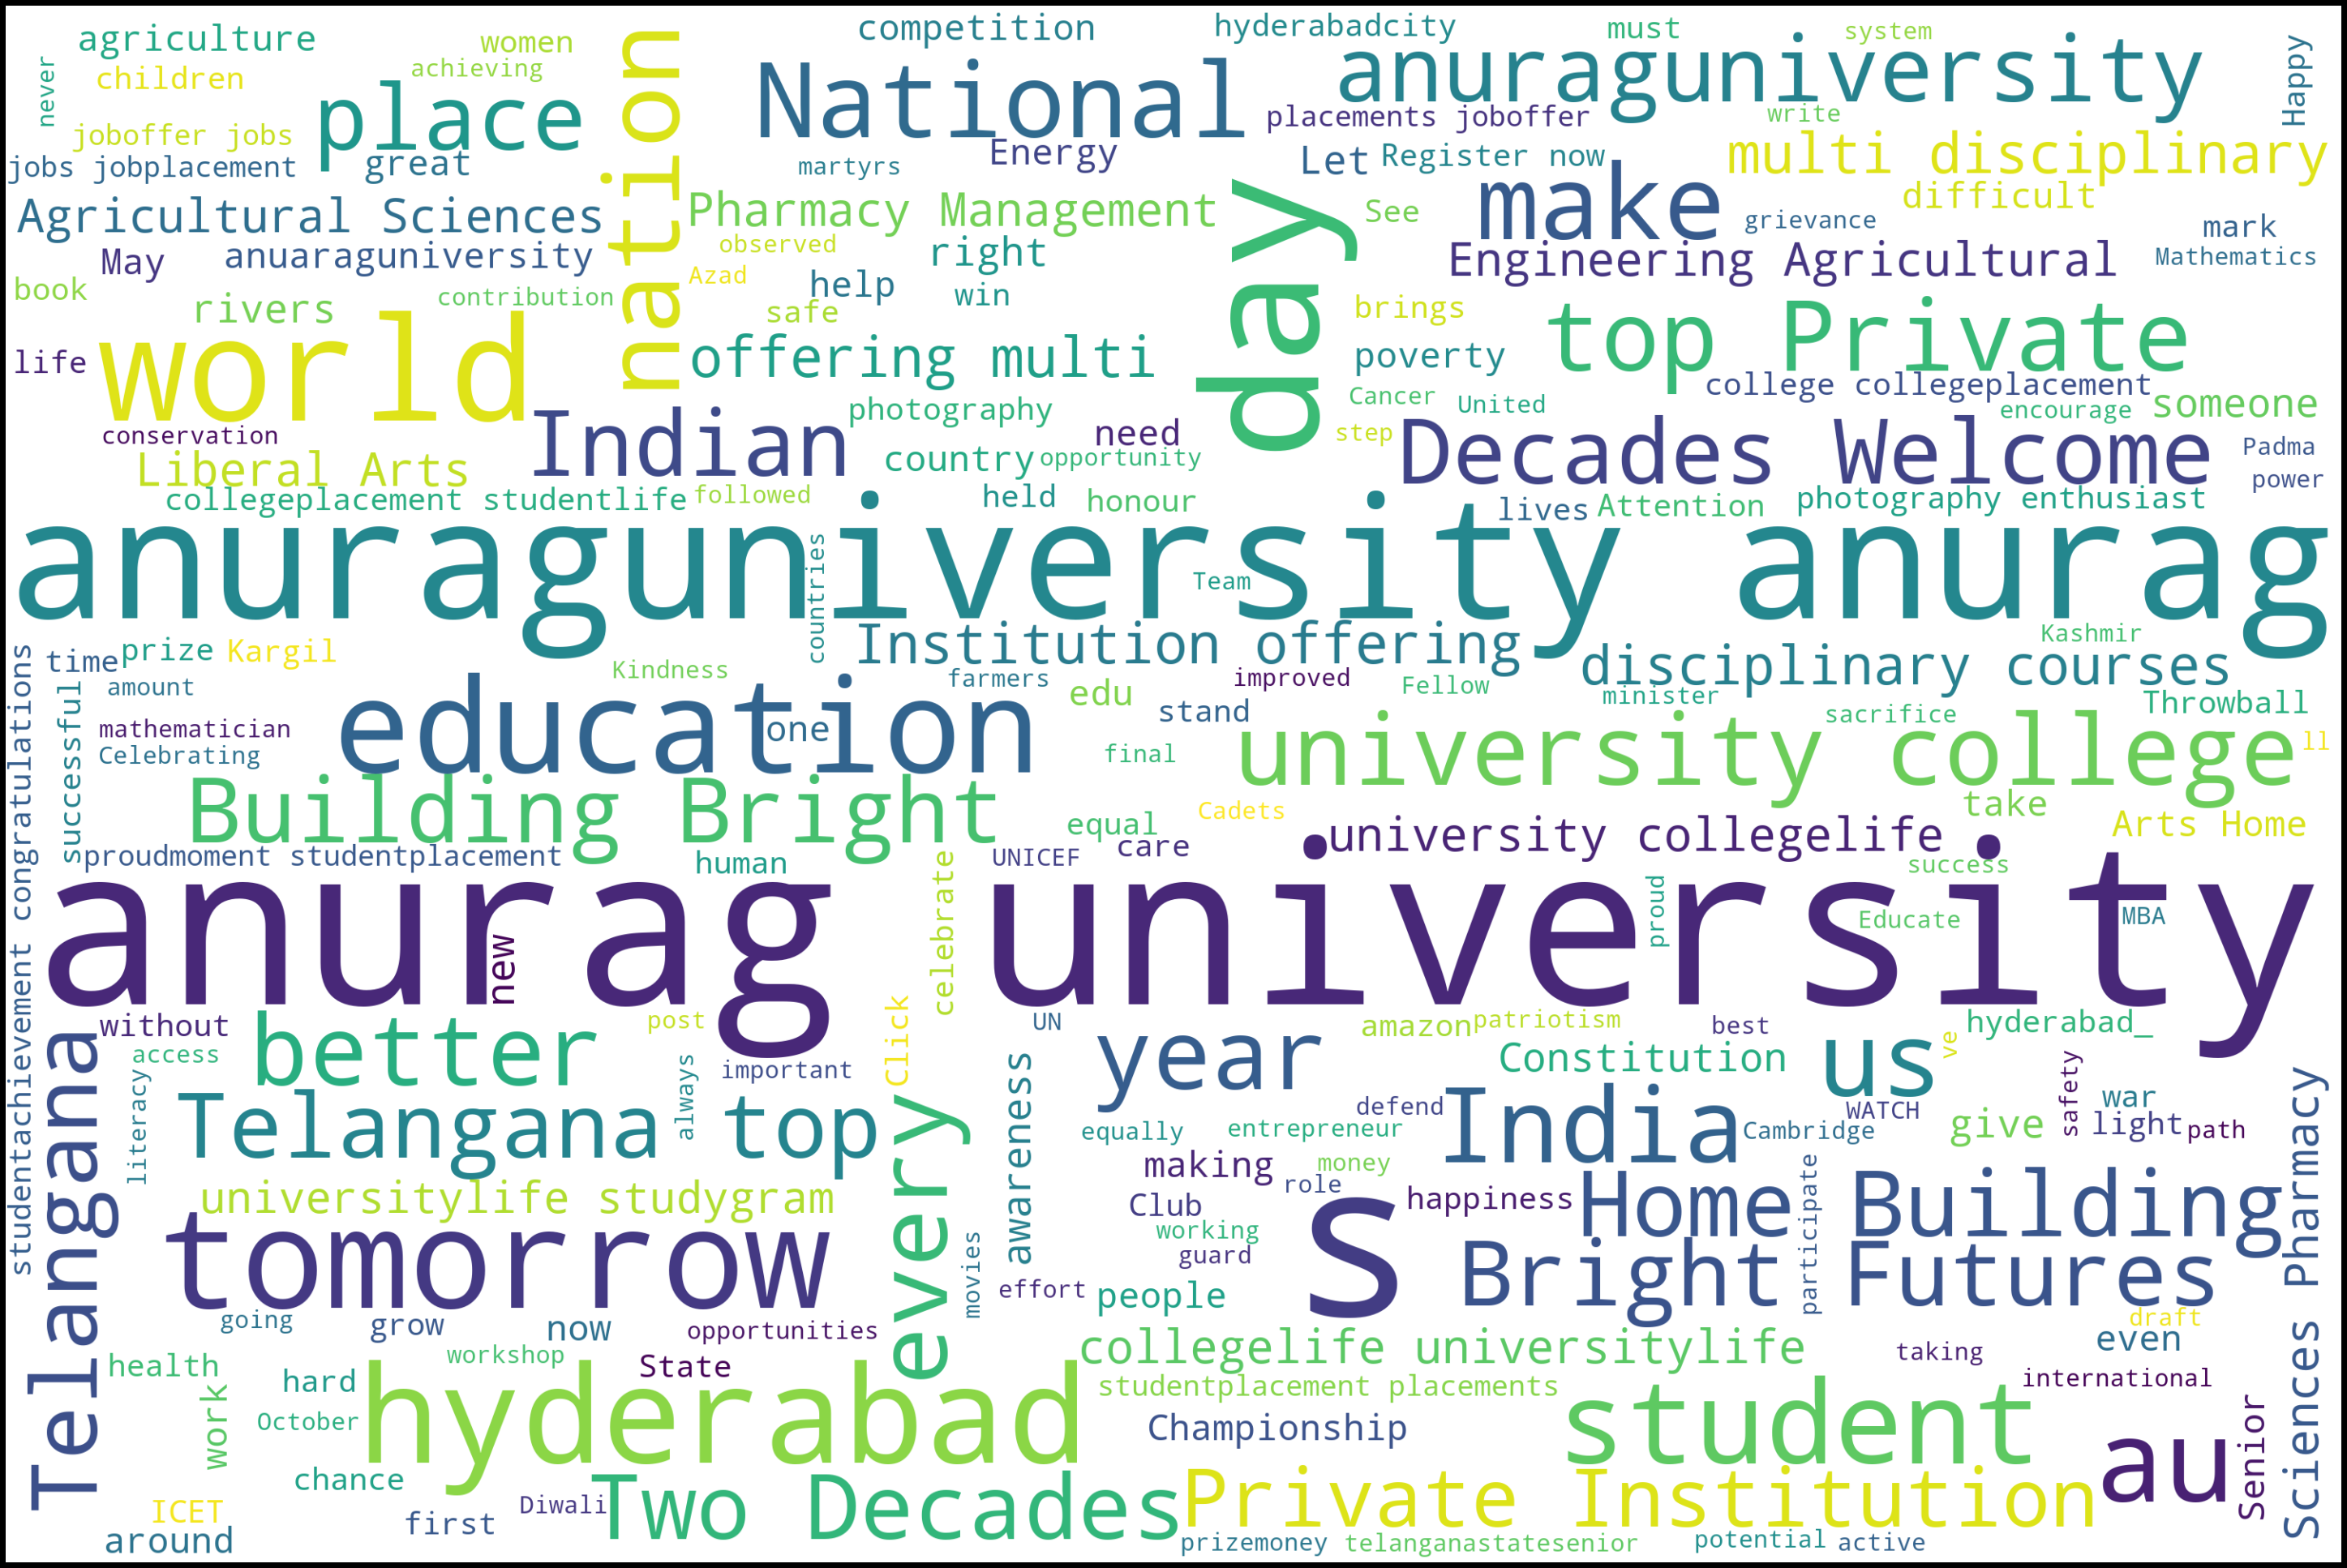

In [22]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(' '.join(df1['headline']))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

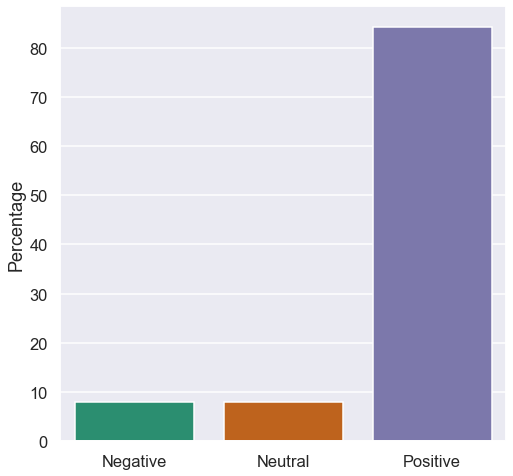

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df1.label.value_counts(normalize=True) * 100

seaborn.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [24]:
negative_titles = df[df['label'] == -1]
negative_titles.head()

neg    neu    pos  compound  \
3   0.241  0.759  0.000   -0.5423   
5   0.538  0.462  0.000   -0.5423   
7   0.068  0.887  0.044   -0.1779   
9   0.219  0.781  0.000   -0.4215   
10  0.174  0.826  0.000   -0.4101   

                                             headline  label  
3   Have you ever just said fuck it and not did an...     -1  
5                                 Am I going to fail?     -1  
7   I am a US citizen and have lived my entire lif...     -1  
9   Do Any of You Regret Choosing the College Majo...     -1  
10  I’m a gay guy moving to college and am so nerv...     -1

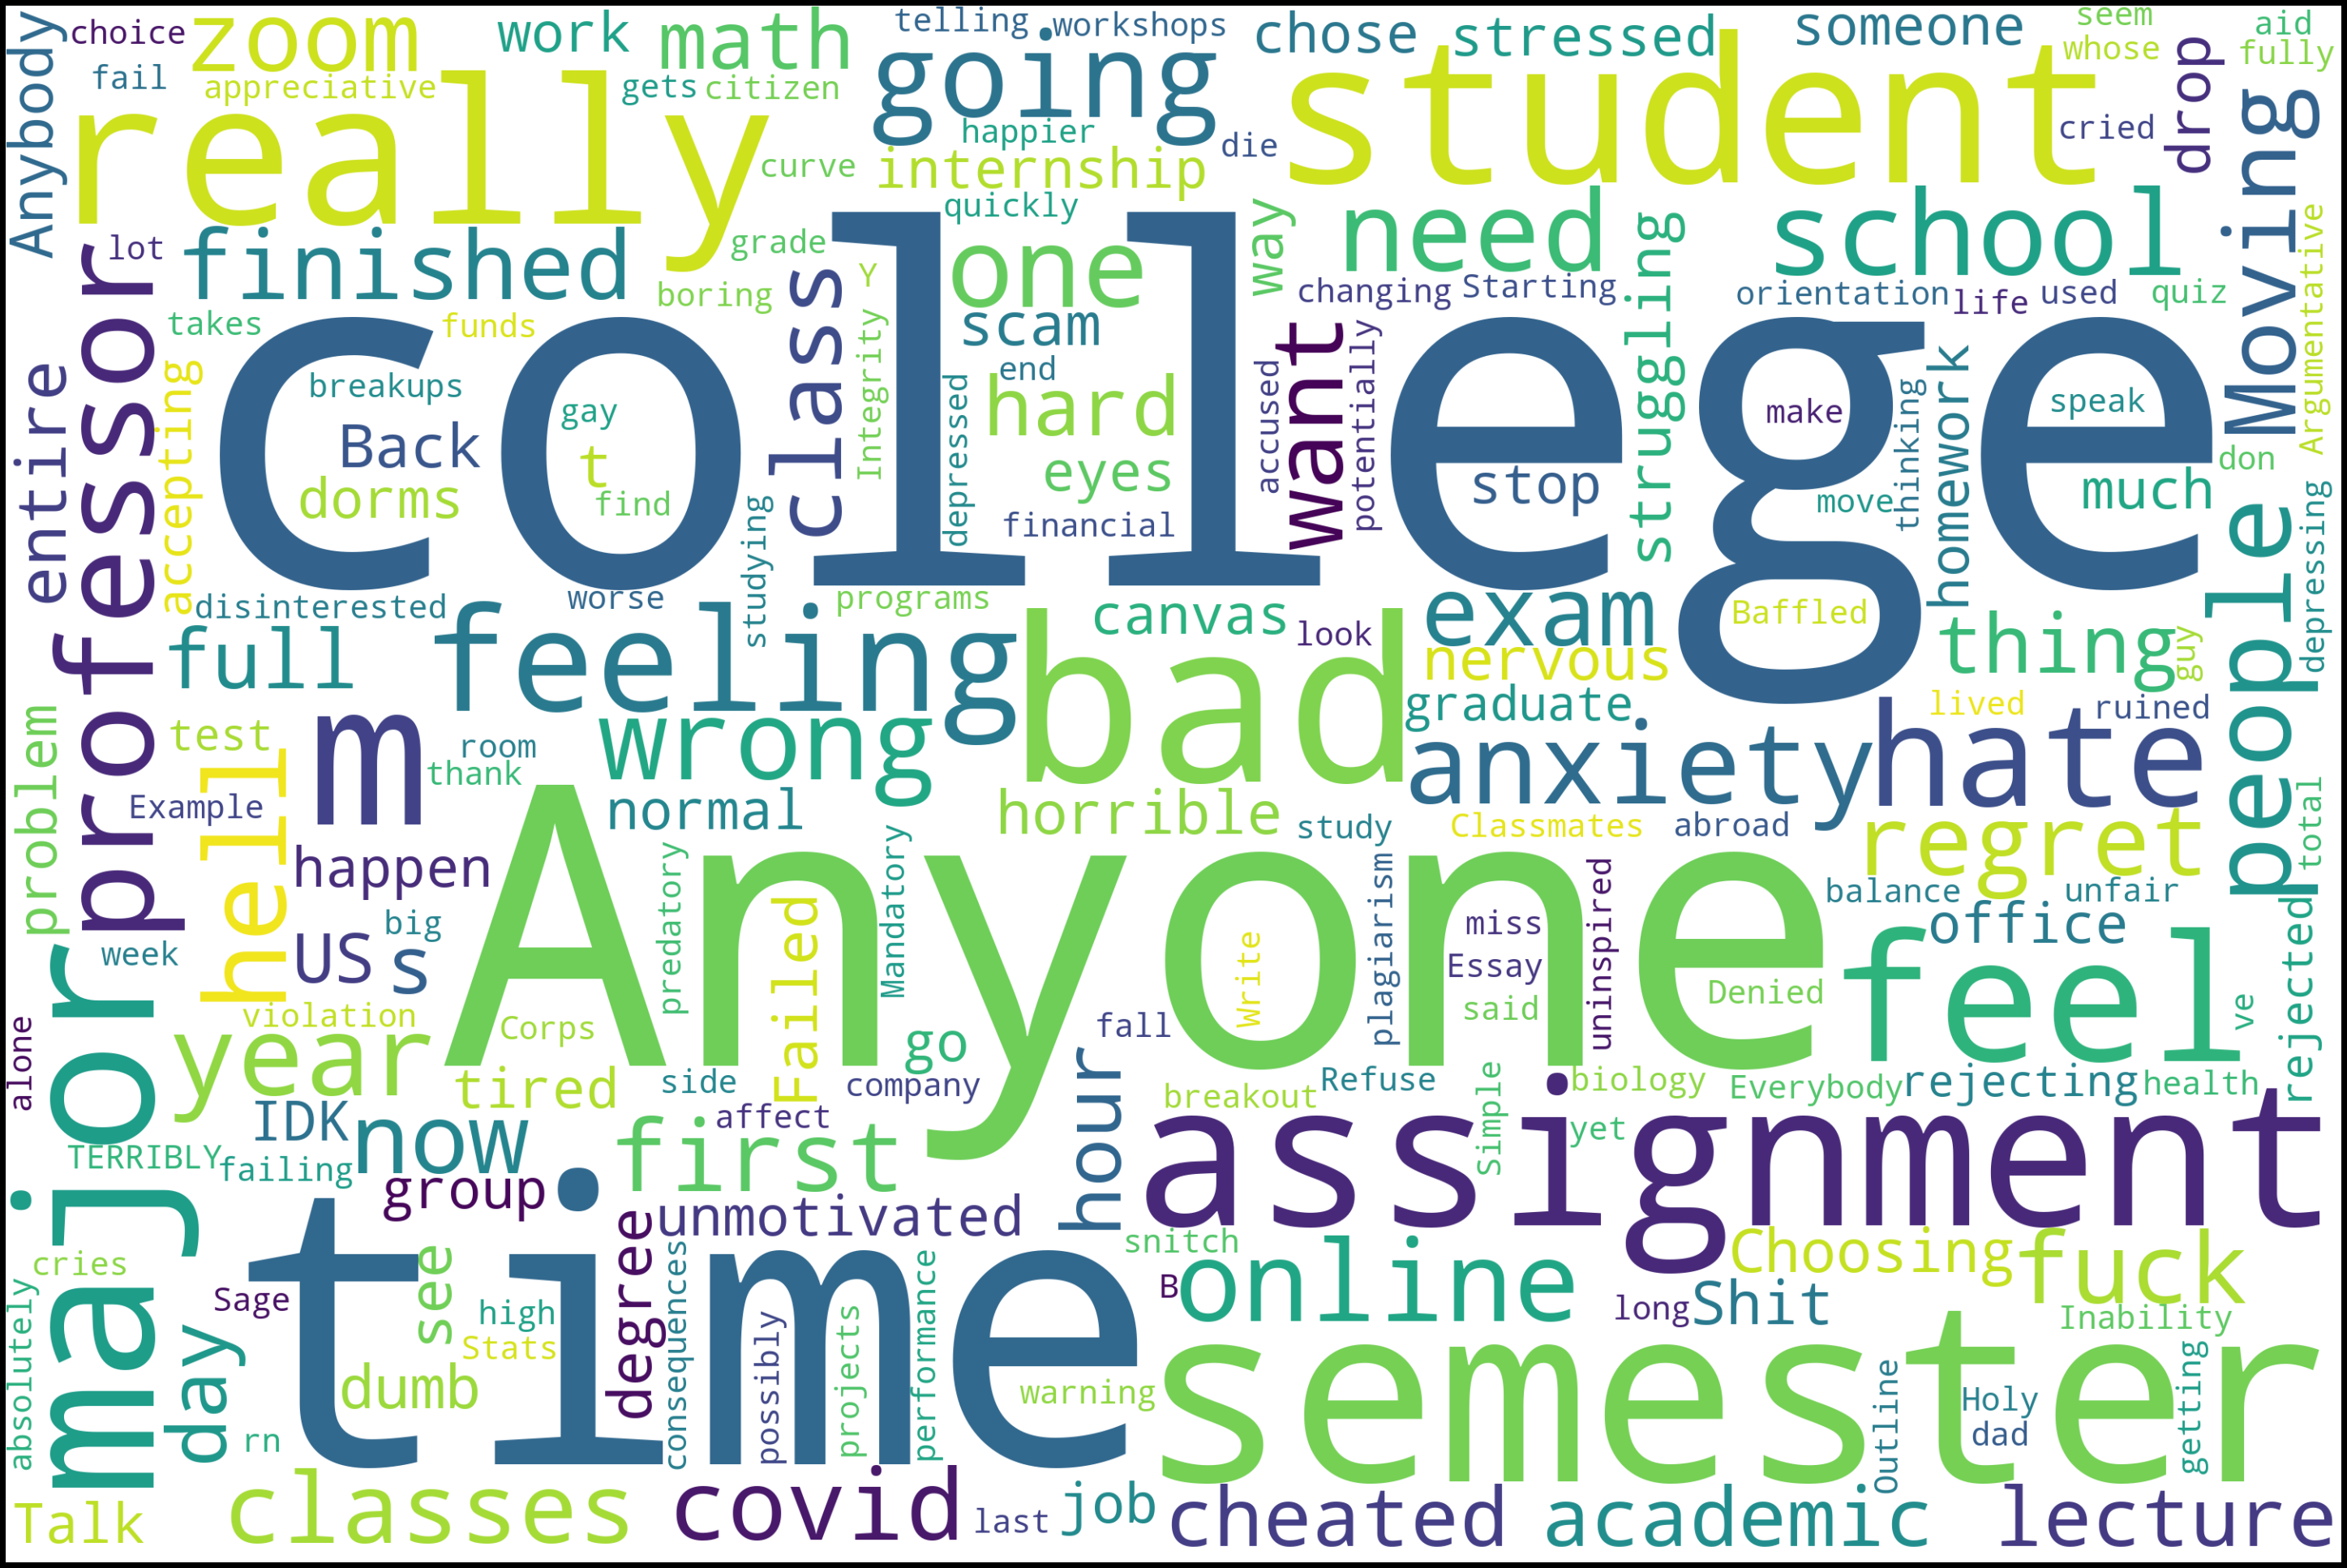

In [25]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(' '.join(negative_titles['headline']))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()